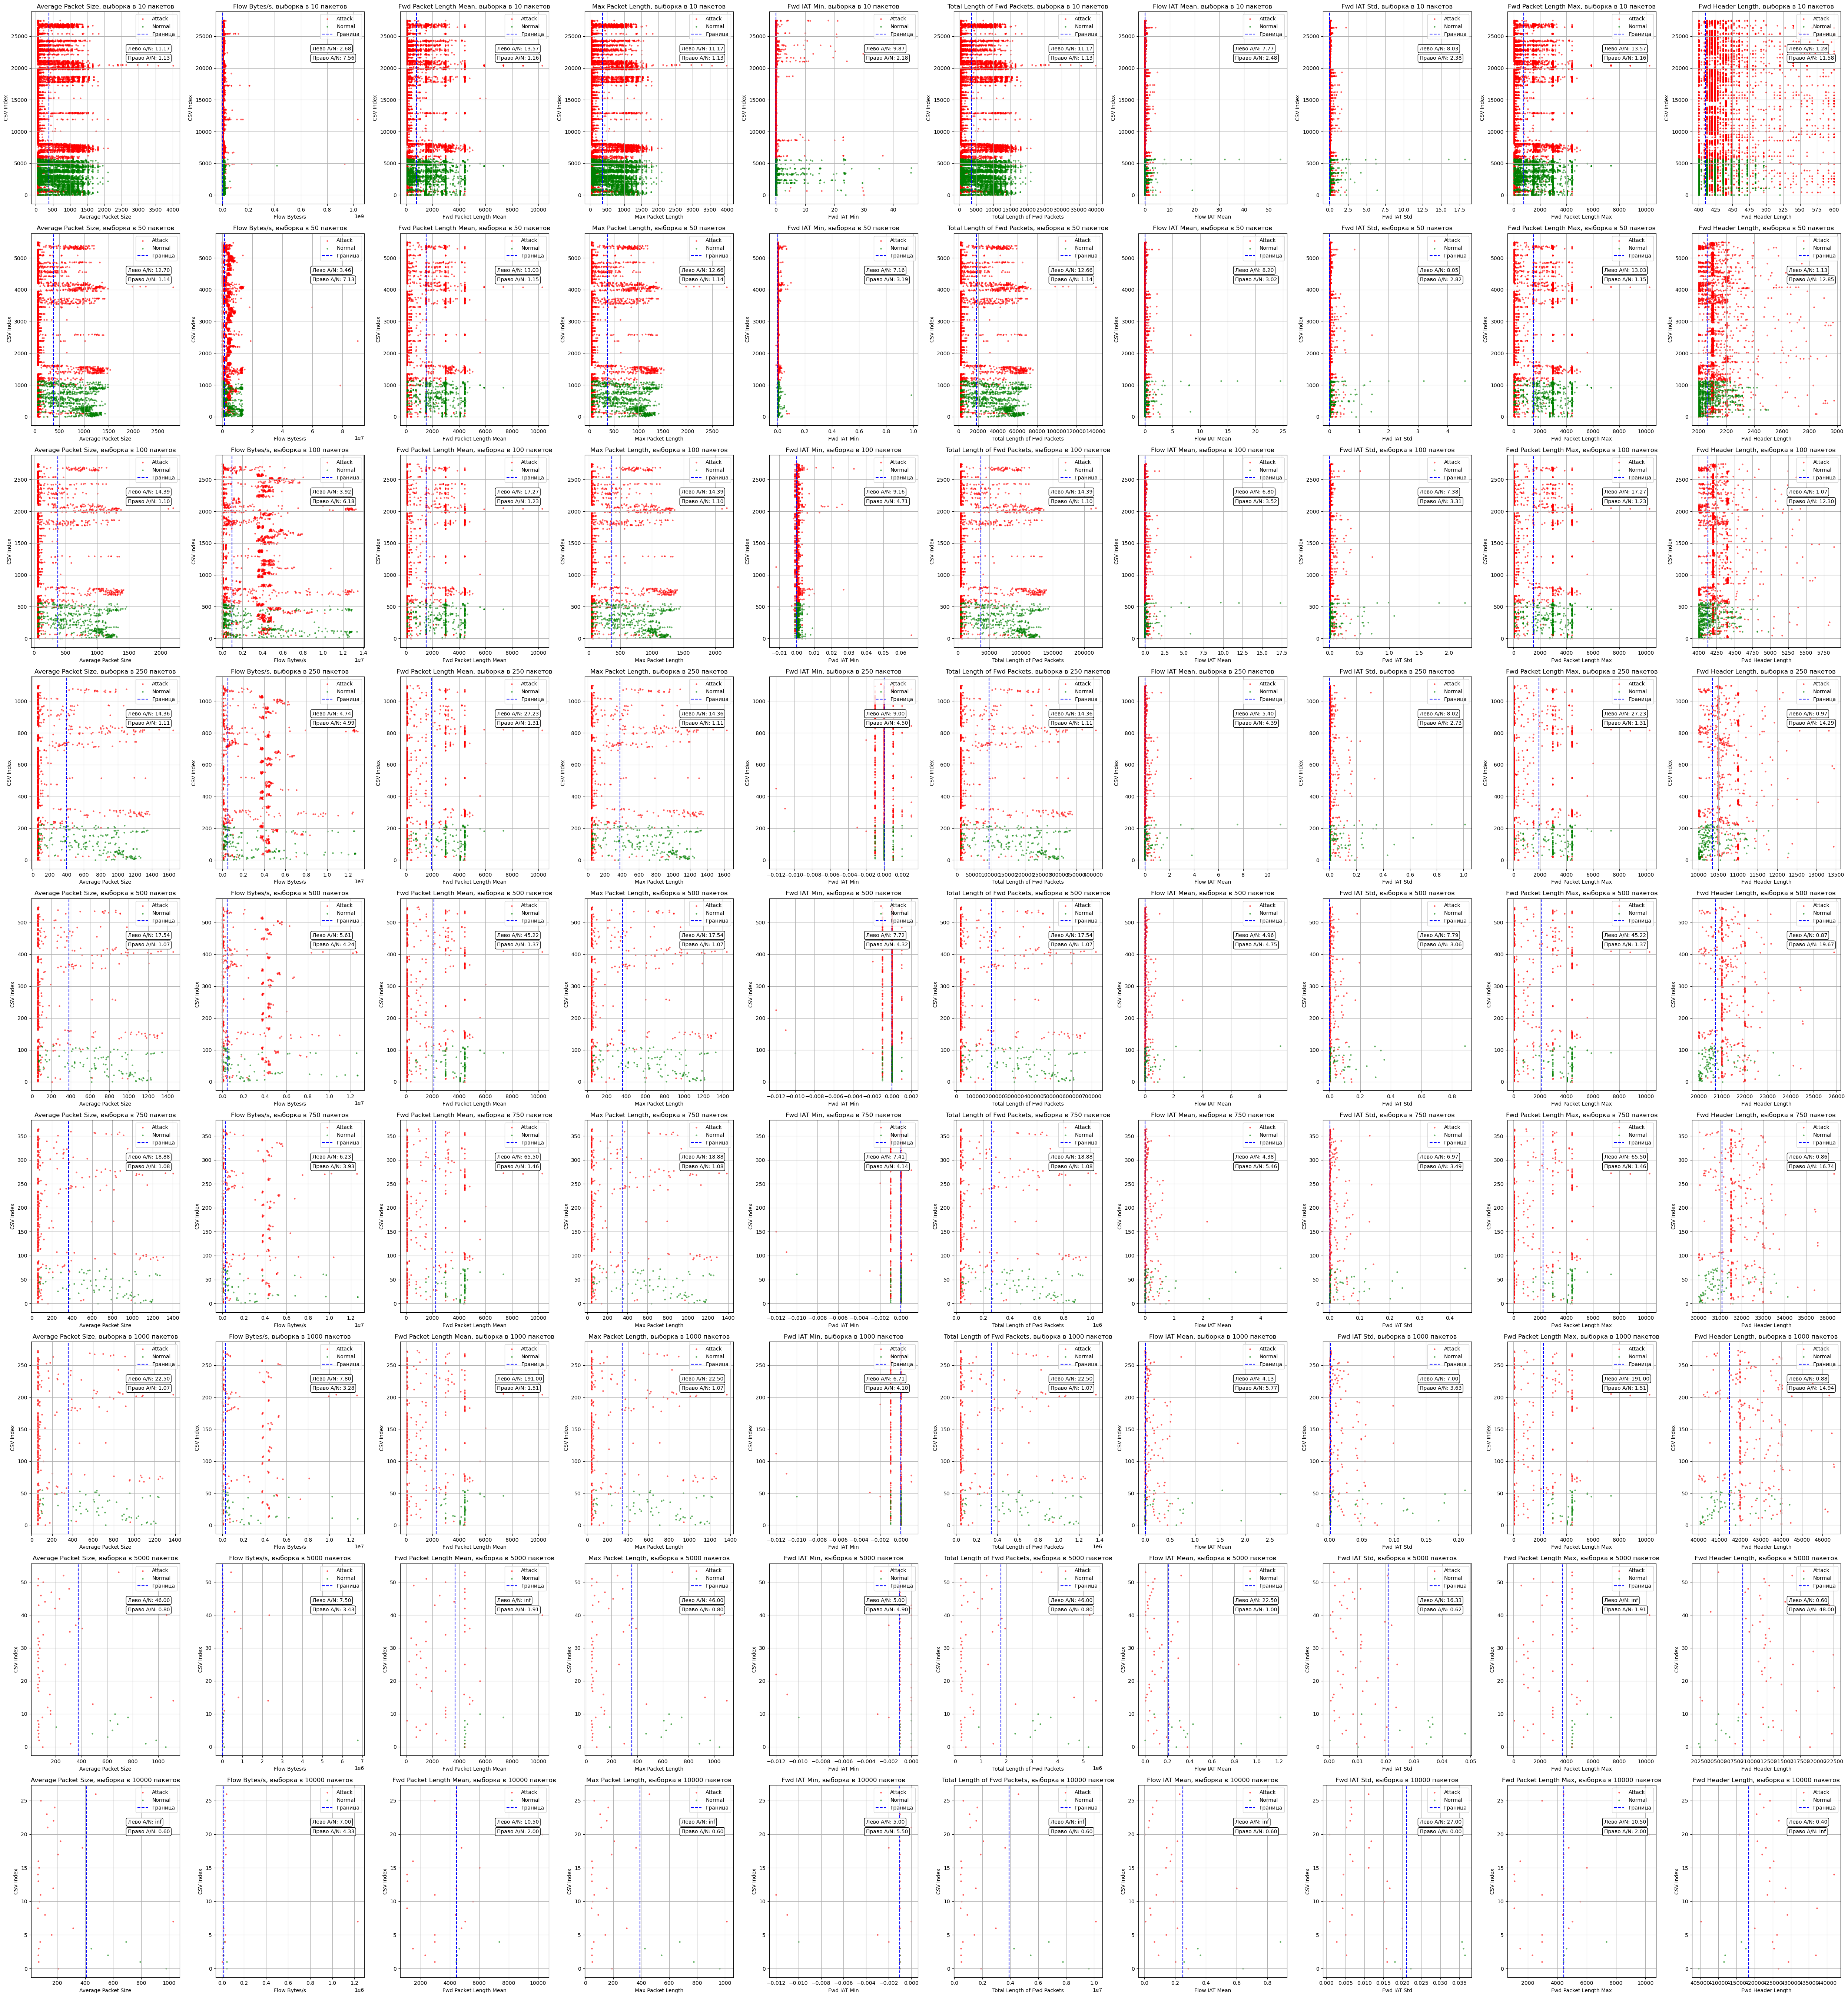

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


def plot_horizontal_graphs_for_pairs(attack_dir, normal_dir):
    # Словарь для хранения пар файлов по длине выборки
    pairs = defaultdict(lambda: {"attack": [], "normal": []})

    # Сопоставление файлов из папки attack и normal по длине выборки
    for file in os.listdir(attack_dir):
        if "_1_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["attack"].append(file)

    for file in os.listdir(normal_dir):
        if "_0_" in file:
            length = int(file.split("_")[-3])
            pairs[length]["normal"].append(file)

    # Подсчет общего количества наборов
    total_pairs = 0

    # Определение столбцов на основе первого набора данных
    for length, file_pairs in pairs.items():
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)

            # Получаем список всех столбцов, кроме 'Label' и 'Index'
            columns = [
                col for col in df_attack.columns if col not in ["Label", "Index"]
            ]
            # Считаем, сколько будет строк из горизонтальных подграфиков в итоговом полотне
            total_pairs += 1

    # Создание общего полотна для всех пар файлов
    fig, axes = plt.subplots(
        total_pairs, len(columns), figsize=(5 * len(columns), 6 * total_pairs)
    )

    # Индекс для строк подграфиков
    row_idx = 0

    # Построение графиков для каждого набора пар
    for length, file_pairs in sorted(pairs.items()):
        attack_file = sorted(file_pairs["attack"])
        normal_file = sorted(file_pairs["normal"])

        # Убедимся, что количество парных файлов совпадает
        if len(attack_file) == len(normal_file):
            attack_path = os.path.join(attack_dir, attack_file[0])
            normal_path = os.path.join(normal_dir, normal_file[0])

            # Загрузка данных из файлов CSV
            df_attack = pd.read_csv(attack_path)
            df_normal = pd.read_csv(normal_path)

            # Добавление идентификаторов строк для сохранения оригинальных индексов
            df_attack["Index"] = range(len(df_attack))
            df_normal["Index"] = range(len(df_normal))

            # Создание подграфиков в строке
            for ax, column in zip(axes[row_idx], columns):
                # Отображение точек
                ax.scatter(
                    df_attack[column],
                    df_attack["Index"],
                    color="red",
                    alpha=0.5,  # Полупрозрачность для attack точек
                    label="Attack",
                    s=5,
                )
                ax.scatter(
                    df_normal[column],
                    df_normal["Index"],
                    color="green",
                    alpha=0.5,  # Полупрозрачность для normal точек
                    label="Normal",
                    s=5,
                )

                # Вычисление медиан
                normal_median = df_normal[column].median()
                attack_median = df_attack[column].median()

                # Средняя линия между медианами
                separation_line = (normal_median + attack_median) / 2

                # Добавление линии границы
                ax.axvline(
                    x=separation_line,
                    color="blue",
                    linestyle="--",
                    label="Граница",
                )

                # Подсчёт точек слева и справа от границы
                left_normal_count = df_normal[
                    df_normal[column] < separation_line
                ].shape[0]
                left_attack_count = df_attack[
                    df_attack[column] < separation_line
                ].shape[0]
                right_normal_count = df_normal[
                    df_normal[column] >= separation_line
                ].shape[0]
                right_attack_count = df_attack[
                    df_attack[column] >= separation_line
                ].shape[0]

                # Подсчёт отношения
                left_ratio = (
                    left_attack_count / left_normal_count
                    if left_normal_count > 0
                    else float("inf")
                )
                right_ratio = (
                    right_attack_count / right_normal_count
                    if right_normal_count > 0
                    else float("inf")
                )

                # Добавление аннотаций на график
                ax.annotate(
                    f"Лево A/N: {left_ratio:.2f}",
                    xy=(0.65, 0.8),
                    xycoords="axes fraction",
                    fontsize=10,
                    bbox=dict(
                        facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"
                    ),
                )
                ax.annotate(
                    f"Право A/N: {right_ratio:.2f}",
                    xy=(0.65, 0.75),
                    xycoords="axes fraction",
                    fontsize=10,
                    bbox=dict(
                        facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"
                    ),
                )

                ax.set_title(f"{column}, выборка в {length} пакетов")
                ax.set_xlabel(column)
                ax.set_ylabel("CSV Index")

                # Фиксируем легенду в правом верхнем углу
                ax.legend(loc="upper right")

                ax.grid(True)

            row_idx += 1

    # Устанавливаем плотное расположение графиков
    plt.tight_layout()

    # Показать все графики на общем полотне
    plt.show()


# Пример использования функции
attack_dir = "./csvs/attack/"
normal_dir = "./csvs/normal/"
plot_horizontal_graphs_for_pairs(attack_dir, normal_dir)